# CCN 2022 Tutorial
This notebook was designed to accompany the [Varieties of Human-like AI](https://2022.ccneuro.org/view_event.php?mid=18) tutorial which took place during CCN 2022. 

It also serves as an interactive introduction to various topics in reinforcement learning for human and animal decision making, and as such may be of general interest.

In [1]:
# Uncomment below lines and run this cell to install neuronav and requirements for colab.

#!git clone https://github.com/awjuliani/neuro-nav
#!pip install ./neuro-nav[experiments_remote]

In [2]:
from neuronav.envs.grid_env import GridEnv, GridSize
from neuronav.envs.graph_env import GraphEnv
from neuronav.agents.td_agents import TDSR, TDQ
from neuronav.agents.dyna_agents import DynaQ, DynaSR
from neuronav.agents.mb_agents import MBV
from neuronav.envs.grid_templates import GridTemplate
from neuronav.envs.graph_templates import GraphTemplate
from neuronav.utils import run_episode, softmax, plot_values_and_policy
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

## 1. The reinforcement learning loop
The reinforcement learning loop consists of a dynamic interaction between two main entities: an `agent` and an `environment`.

The `agent` observes the `state` of the `environment`, and then takes an `action` in the environment. The environment then transitions to a new state based on the action, and provides a `reward` and new state observation to the agent.

We can examine this dynamic with a simple gridworld environment.

![The RL loop](../images/notebooks/rl_loop.png)

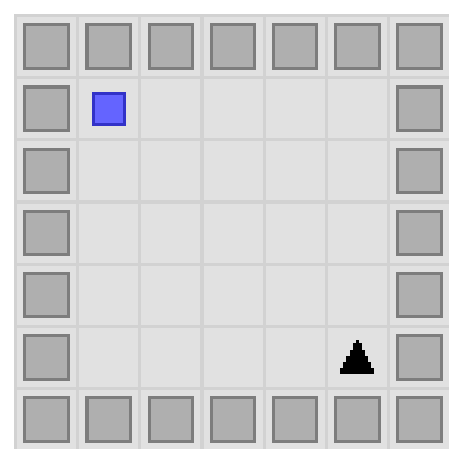

In [26]:
env = GridEnv(size=GridSize.micro)
obs = env.reset()
env.render()

In the image above, the agent location is indicated by the `white square`, and the goal location is indicated by the `green square`. `Grey squares` correspond to walls, and `black squares` correspond to open space. 

![rodent_maze](../images/notebooks/rodent.png)

The agent has four possible actions, movement up (`0`), right (`1`), down (`2`), or left (`3`). 

The agent can act in the environment by calling `env.step(action)`. This will return a new `observation`, `reward`, `done`, and `misc info`. We can ignore these last two for now.

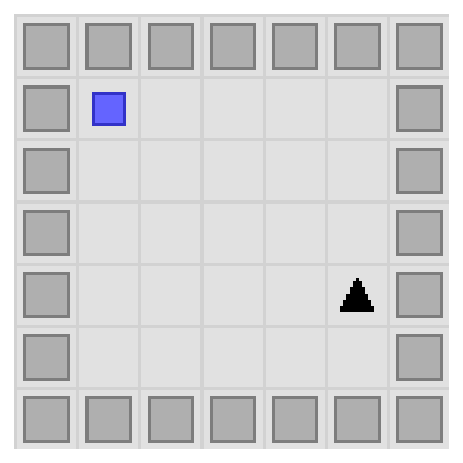

In [4]:
obs, reward, done, _ = env.step(0)  # Lets move up
env.render()  # This rendered the current state of the environment

One action isn't enough for our agent to reach the goal. 

We can keep moving the agent until it reaches the goal by providing it a sequence of actions we know will get it there.

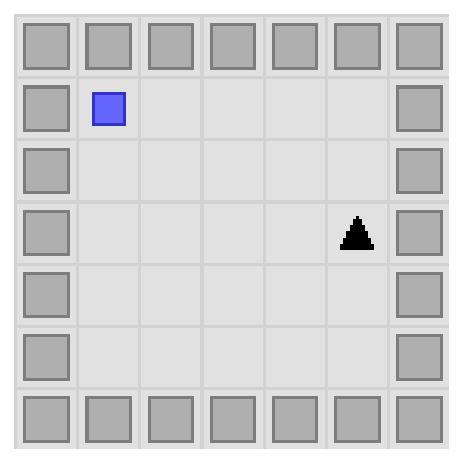

Action: 0, Reward: 0.0


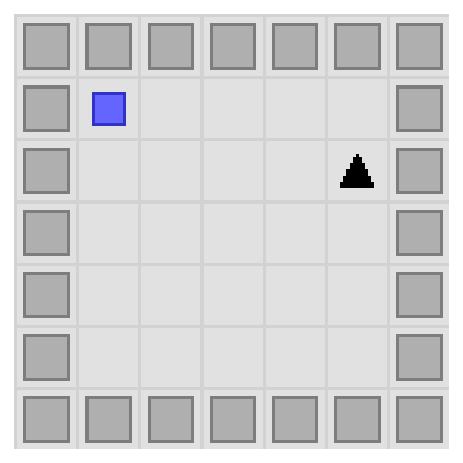

Action: 0, Reward: 0.0


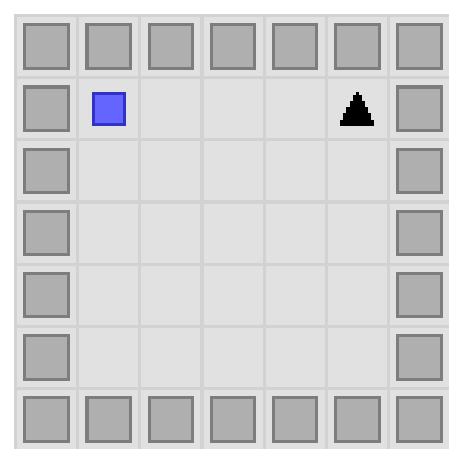

Action: 0, Reward: 0.0


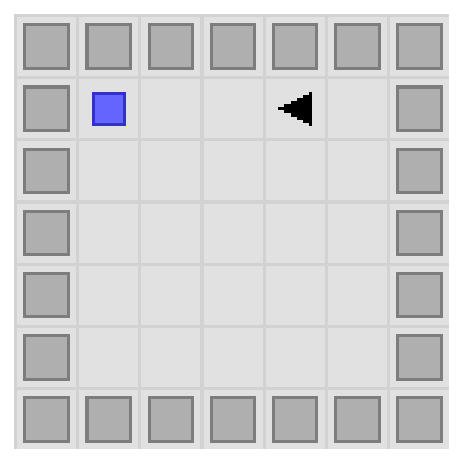

Action: 3, Reward: 0.0


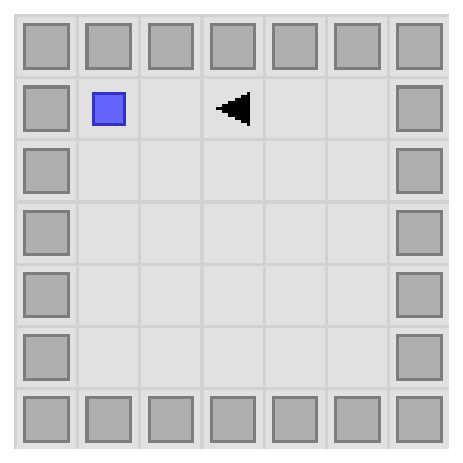

Action: 3, Reward: 0.0


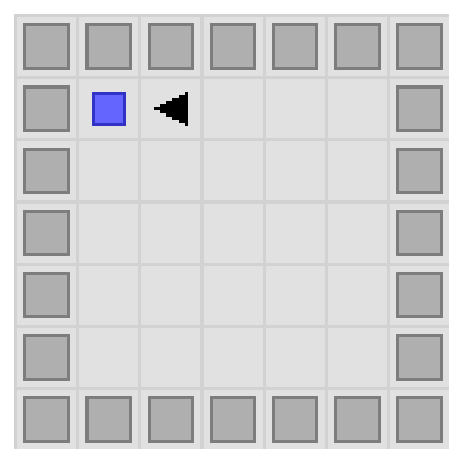

Action: 3, Reward: 0.0


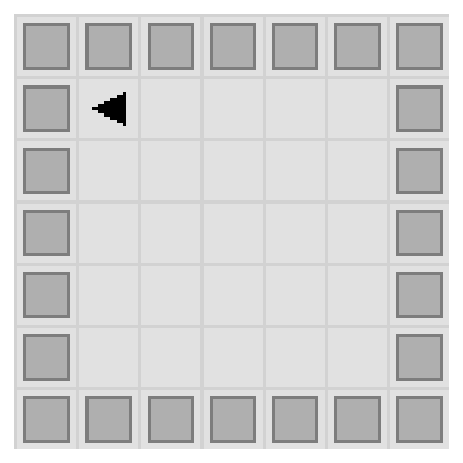

Action: 3, Reward: 1.0


In [5]:
actions = [0, 0, 0, 3, 3, 3, 3]  # The optimal action sequence

for idx, action in enumerate(actions):
    obs, reward, done, _ = env.step(action)
    env.render()
    print(f"Action: {action}, Reward: {reward}")

The agent reached the goal location! 

Of course, the point of reinforcement learning is to devise ways for agents to learn optimal actions on their own, rather than having humans hand-design action sequences. We will explore this next.

### Bonus Questions

* What are some of the cognitive mechanisms which allow us to easily determien the optimal action sequence?

* Can you think of a simple way to algorithmically arrive at an action-sequence which reaches the goal that doesn't involve reinforcement learning? 

## 2. Model-free learning in bandit tasks
Before describing algorithms capable of solving mazes, we can take a step back, and begin with an even simpler learning problem: how can we derive an agent which learns to make the optimal choice among a set of possible actions. Named after the slot machines found in casinos, this class of problems is referred to as multi-arm bandits (Gittins, 1979).

We can instantiate a simple environment (`three_arm_bandit`), where the agent has three possible actions (`0`, `1`, or `2`) it can take, each with a unique possible outcome: a reward of `+1`, a reward of `+0.5` or a reward of `-1`. In this case, action `0` is optimal, but we would like an agent to learn that information from scratch.

![one_step](../images/notebooks/one_step.png)

In addition to `three_arm_bandit`, Neuro-Nav includes a number of pre-defined environment structures and tasks. The list of the tasks and environments is available [here](../neuronav/envs/README.md).

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


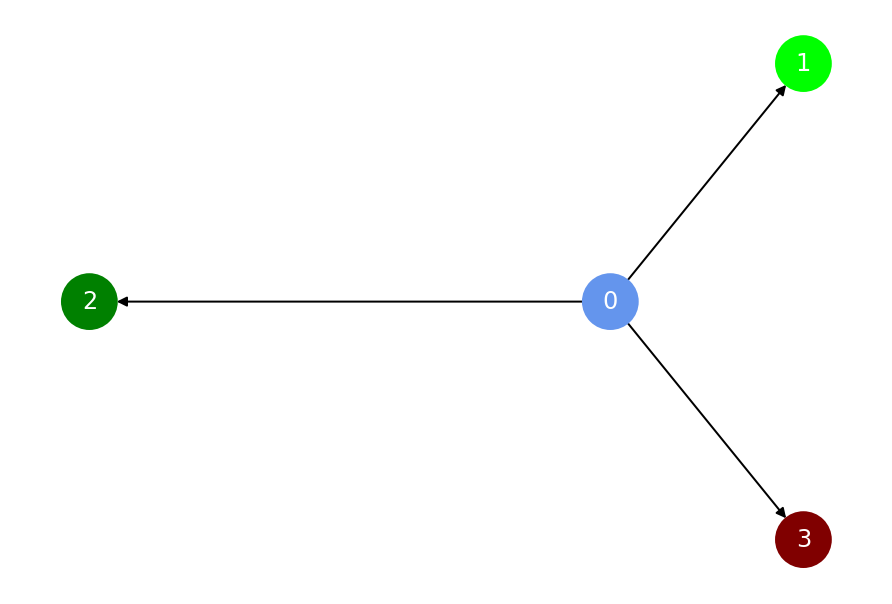

In [6]:
env = GraphEnv(template=GraphTemplate.three_arm_bandit)
obs = env.reset()
env.render()

### 2.1 Learning a Q-function by taking random actions

In order to learn the expected value of each action, we will use a simple form of value esimtation called Q-learning (Watkins & Dayan, 1992). In Q-learning, we learn a state-action value function called a Q-function. As it is a function of both the state and the action, it is often written as `Q(s,a)`. Since we have only one state from which we are trying to estimate the action values, we can also think of it as `Q(a)` in this context.

![Q(a) Agent](../images/notebooks/q_a.png)

We can begin by instantiating a simple tabular Q learning agent. In this agent, the Q-function is look up table for cached-value, in the form of a matrix of shape `[NUM_ACTIONS X NUM_STATES]`. The code for this agent is available [here](../neuronav/agents/td_agents.py).

In [7]:
agent = TDQ(env.state_size, env.action_space.n)
print(f"Q-values: {agent.Q[:,0]}")

Q-values: [0. 0. 0.]


We can examine the first column of the matrix, since we are only concerned with learning action-values for the starting state. Since the agent has not learned anything yet, all the values are initialized to zero.

A simple update rule is then used to modify the Q values as the agent interacts with its environment.

$$Q(a) = Q(a) + \alpha * (r - Q(a))$$

Where `alpha` is the learning rate, and `r` is the reward.

With Neuro-Nav, this update takes place automatically when passing the experience tuple `<obs, action, next_obs, reward>` to the `agent.update()` function.

We can see after 1000 trials of taking random actions that the agent's Q-values now match the true reward function of the environment.

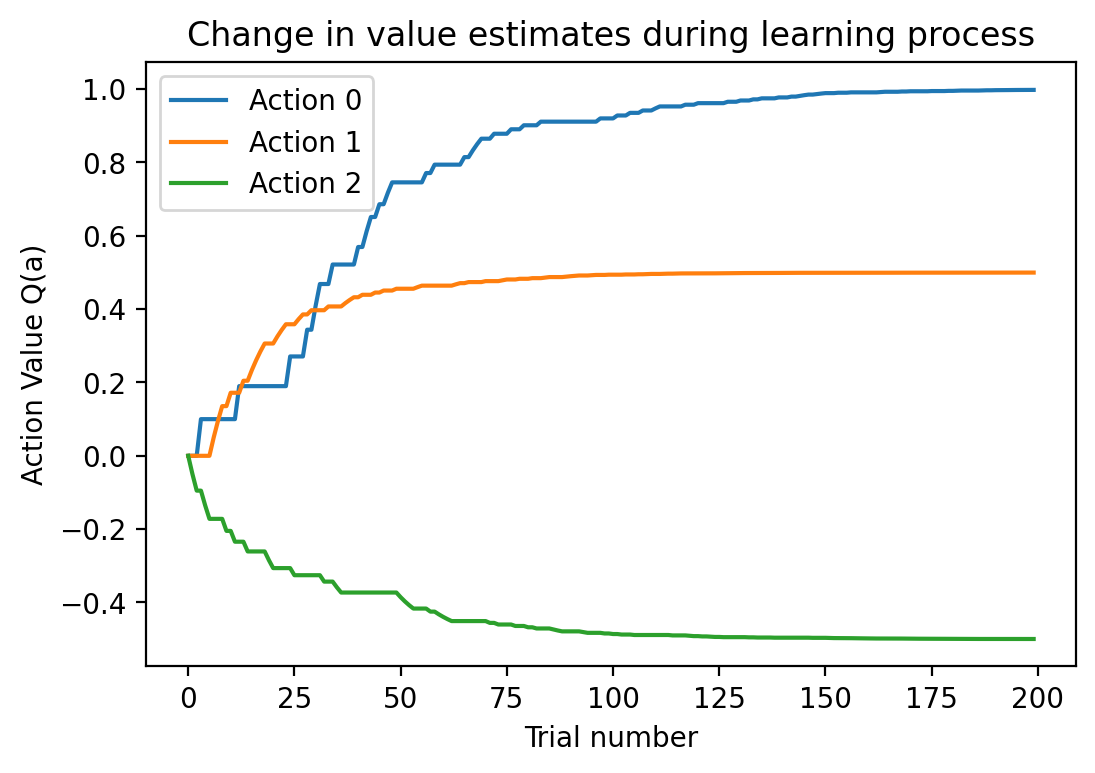

[ 0.99800332  0.49977161 -0.49961322]


In [8]:
num_trials = 200

q_values = []
for i in range(num_trials):
    obs = env.reset()
    action = env.action_space.sample()
    next_obs, reward, done, _ = env.step(action)
    q_values.append(agent.Q[:, 0].copy())
    agent.update([obs, action, next_obs, reward, done])

plt.plot(q_values, label=["Action 0", "Action 1", "Action 2"])
_ = plt.title("Change in value estimates during learning process")
_ = plt.ylabel("Action Value Q(a)")
_ = plt.xlabel("Trial number")
plt.legend()
plt.gcf().set_dpi(100)
plt.show()

print(agent.Q[:, 0])

### 2.2 Learning a Q-function while trading off exploration and exploitation

So far, our agent has been taking only random actions. In reality, we will want an agent which can balance exploration and exploitation during the learning process. Neuro-Nav includes two types of policies for negotiating this trade-off, a `softmax` policy, and an `egreedy` policy. 

The `softmax` policy weights the liklihood of each action by the current value estimate using a softmax function. 

The `egreedy` policy uses an `epsilon` parameter to determine the probablility of either taking the action with the highest value estimate, or a random action. 

The code for these two policy types is available [here](../neuronav/agents/base_agent.py).

Below we will examine using a `softmax` policy during learning in our bandit task.

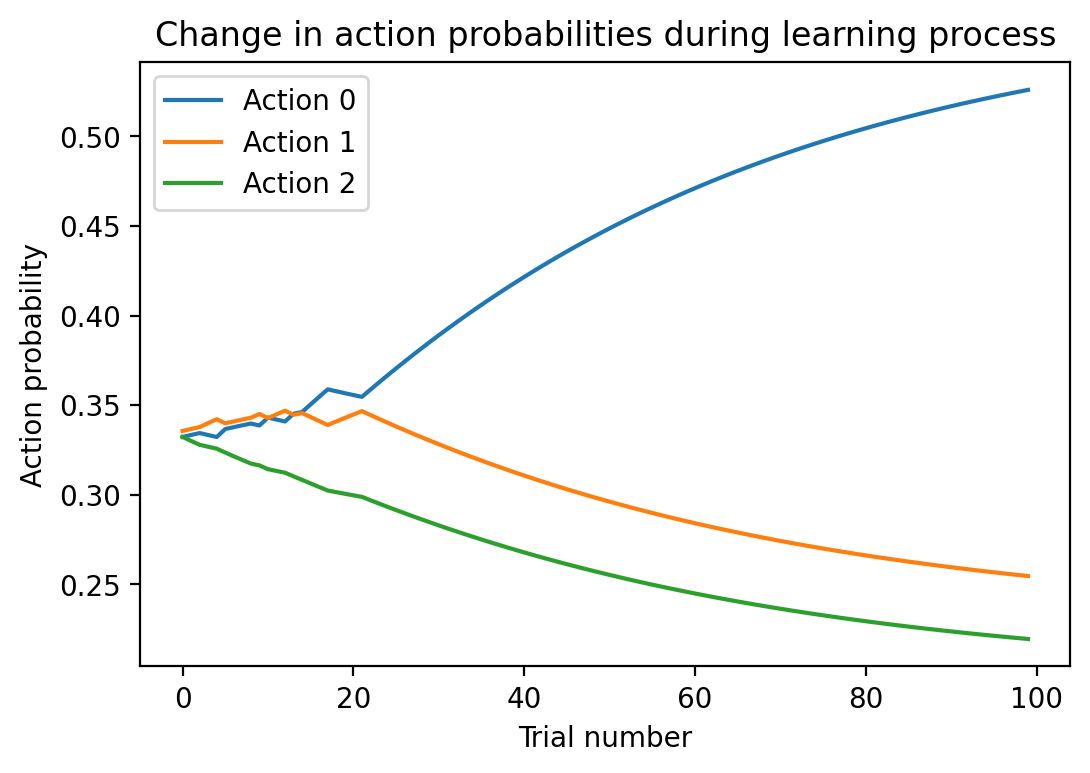

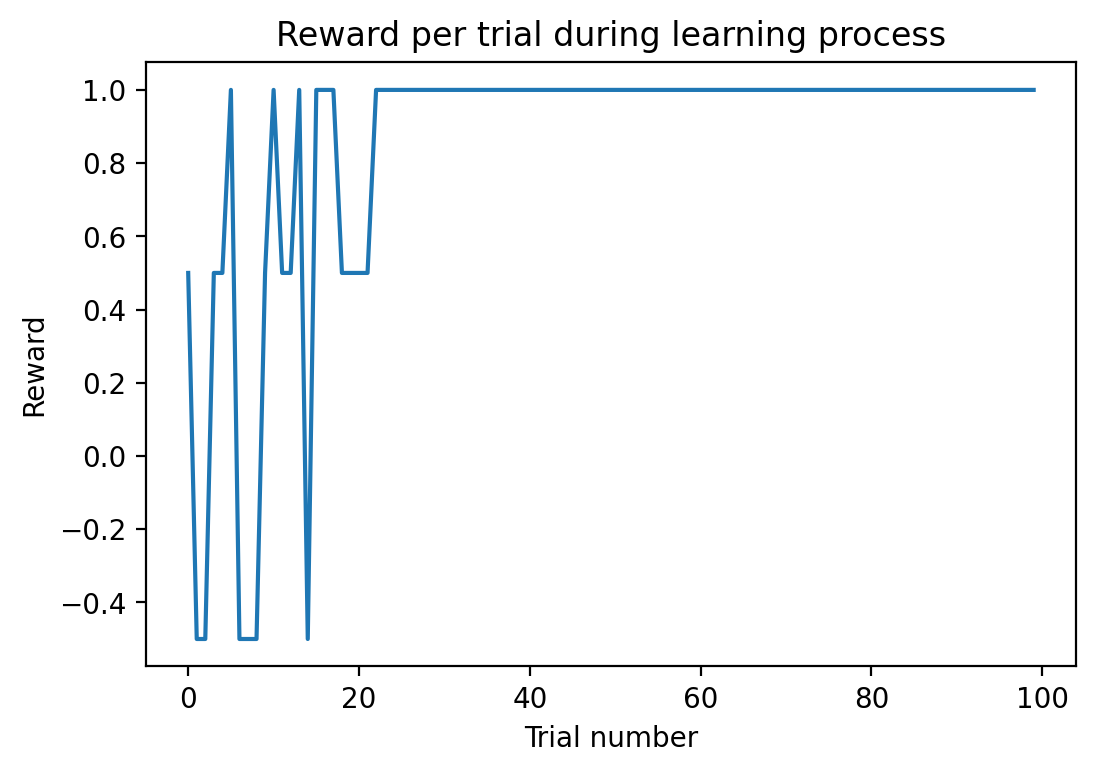

In [9]:
num_trials = 100
lr = 2e-2
beta = 1e1

agent = TDQ(env.state_size, env.action_space.n, poltype="softmax", lr=lr, beta=beta)

rewards = []
probs = []
for i in range(num_trials):
    obs = env.reset()
    action = agent.sample_action(obs)
    next_obs, reward, done, _ = env.step(action)
    agent.update([obs, action, next_obs, reward, done])
    rewards.append(reward)
    probs.append(softmax(agent.Q[:, 0]))

plt.plot(probs, label=["Action 0", "Action 1", "Action 2"])
plt.legend()
_ = plt.title("Change in action probabilities during learning process")
_ = plt.ylabel("Action probability")
_ = plt.xlabel("Trial number")
plt.gcf().set_dpi(100)
plt.show()
plt.plot(rewards)
_ = plt.title("Reward per trial during learning process")
_ = plt.ylabel("Reward")
_ = plt.xlabel("Trial number")
plt.gcf().set_dpi(100)
plt.show()

As we can see, the agent quickly learns to favor the `0` action. This is reflected in the change in action probabilities, as well as the increase in episodic reward which comes from selecting the action which provides the `+1` reward.

### Bonus Questions

* What would the action probabilities look like during learning for the `egreedy` policy time?

* The `softmax` action selection policy uses a `beta` parameter to determine the weight placed on high-value actions. What would changing the `beta` do to the exploration/exploitation trade-off?

* Can you think of other intelligent action-selection methods aside from the two described here?

## 3. Model-free learning in sequential decision making tasks

Most interesting problems involve sequences of decision, rather than single isolated actions. Here we extend the simple Q-learning algorithm to this class of sequential decision making problems. This is done by modifying the Q-learning update equation presented above as follows.

$$ Q(s, a) = Q(s, a) + \alpha * (r + \gamma * Q(s', a^{max}) - Q(s, a)) $$

Where `gamma` is the discount factor, which determines how much to weight to place on expected future outcomes.

`s'` and `a'` likewise correspond to the next (or successor) state and action of the agent.

Intuitively, this equation corresponds to adjusting the state-action value estimate for a given state-action pair toward the observed reward plus a discounted estimate of future expected value. 

This is called a temporal difference update (TD), since we are taking into account the expected outcomes in the future.

![q_sa agent](../images/notebooks/q_sa.png)

### 3.1 Using Q-learning to solve a two-step task

We can examine how this learning process takes place in a slightly more complex environment. Below is a version of the two-step decision making task (Glascher et al., 2010), where the agent must make two binary decisions in a sequence. The optimal action sequence is `0, 0`, which leads to a reward of `+1`.

![two_step](../images/notebooks/two_step.png)

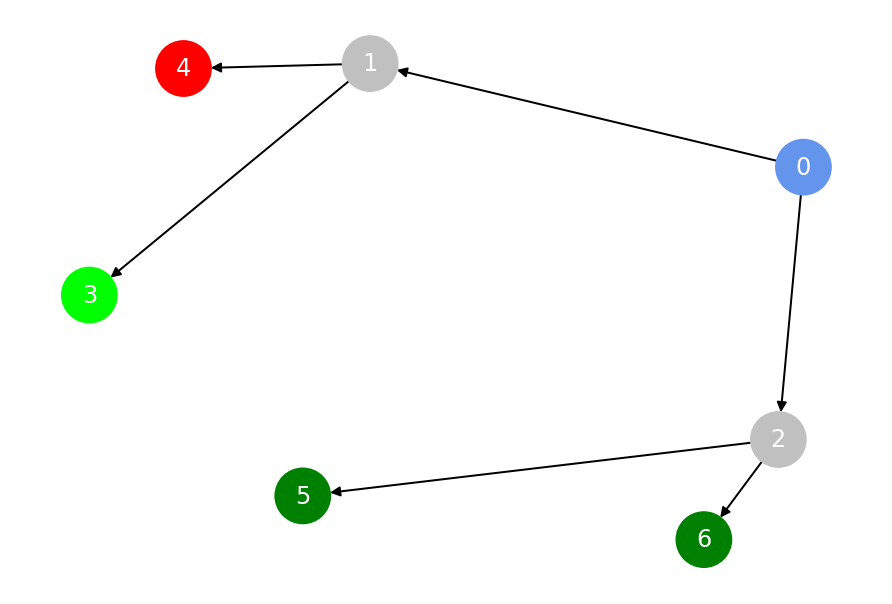

In [10]:
env = GraphEnv(template=GraphTemplate.two_step)
obs = env.reset()
env.render()

We can use our temporal difference q-learning agent to solve this more complex decision-making task.

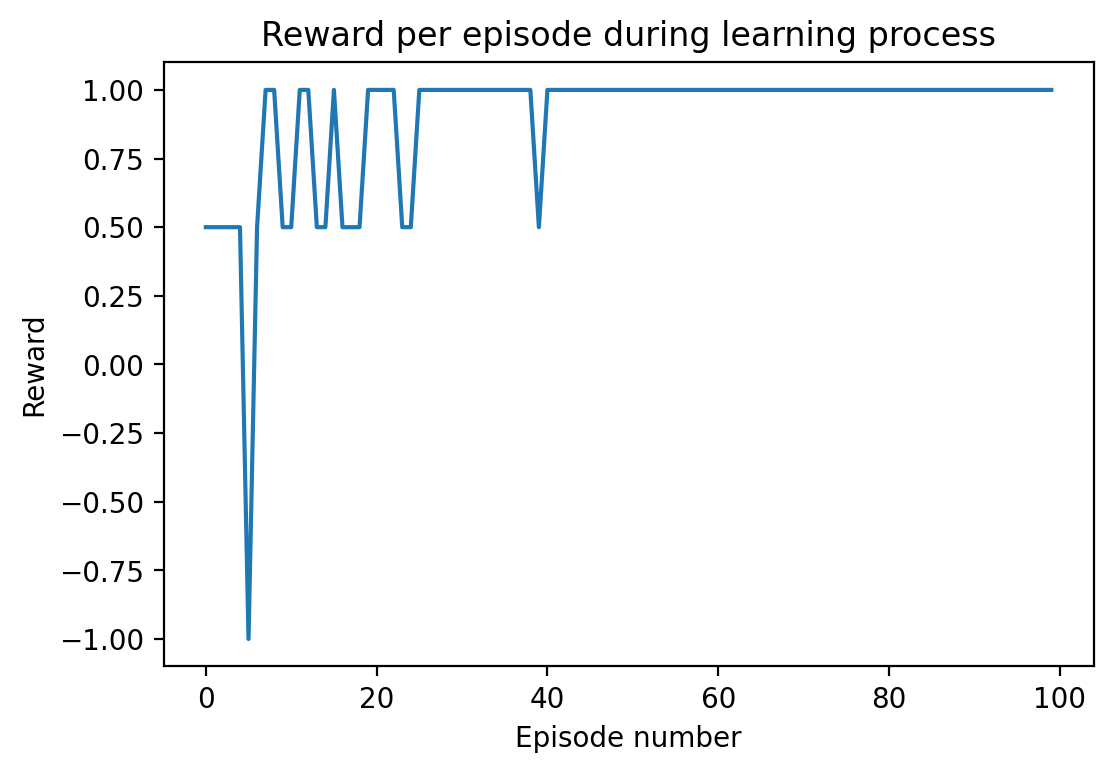

In [11]:
num_episodes = 100
lr = 5e-2
beta = 1e1

agent = TDQ(env.state_size, env.action_space.n, poltype="softmax", lr=lr, beta=beta)

rewards = []
for i in range(num_episodes):
    done = False
    obs = env.reset()
    while not done:
        action = agent.sample_action(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.update([obs, action, next_obs, reward, done])
        obs = next_obs
    rewards.append(reward)

plt.plot(rewards)
_ = plt.title("Reward per episode during learning process")
_ = plt.ylabel("Reward")
_ = plt.xlabel("Episode number")
plt.gcf().set_dpi(100)
plt.show()

As is evident from the plot above, after some trials and error over the course of about 50 episodes, the agent eventually learns to select the optimal action sequence to arrive consistently at the `+1` reward.

### 3.2 Using Q-learning to solve a maze navigation task

Finally, we can take the same TD Q-learning algorithm which solves the two-step task and apply it to our original maze environment, which involves longer-term credit assignment and a more complex action space.

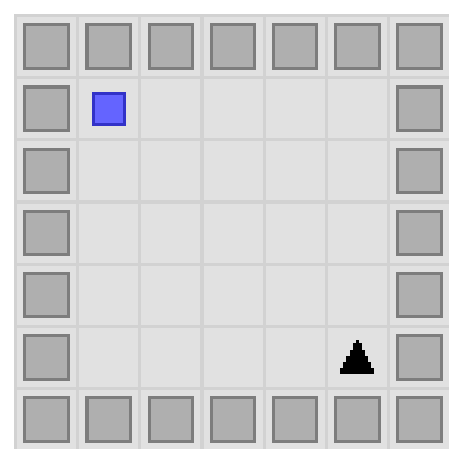

In [12]:
env = GridEnv(size=GridSize.micro)
obs = env.reset()
env.render()

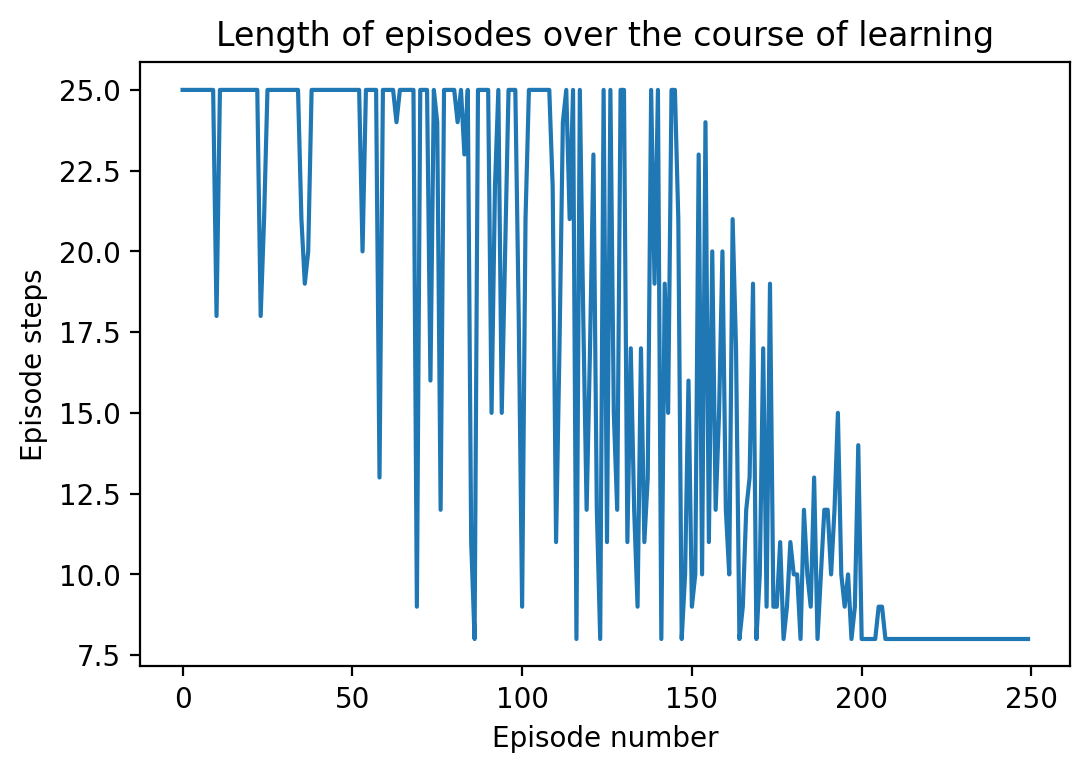

In [13]:
num_episodes = 250
num_steps = 25
lr = 5e-2
beta = 1e2

agent = TDQ(env.state_size, env.action_space.n, poltype="softmax", lr=lr, beta=beta)

episode_steps = []
for i in range(num_episodes):
    done = False
    steps = 0
    obs = env.reset()
    while not done and steps < num_steps:
        action = agent.sample_action(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.update([obs, action, next_obs, reward, done])
        obs = next_obs
        steps += 1
    episode_steps.append(steps)

plt.plot(episode_steps)
_ = plt.title("Length of episodes over the course of learning")
_ = plt.ylabel("Episode steps")
_ = plt.xlabel("Episode number")
plt.gcf().set_dpi(100)
plt.show()

After 200 episodes of experience, the agent has learned the optimal action sequence to reach the goal state.

We can visualize the learned value estimates for each state by averaging over the actions. 

Darker blue corresponds to greater value estimates.

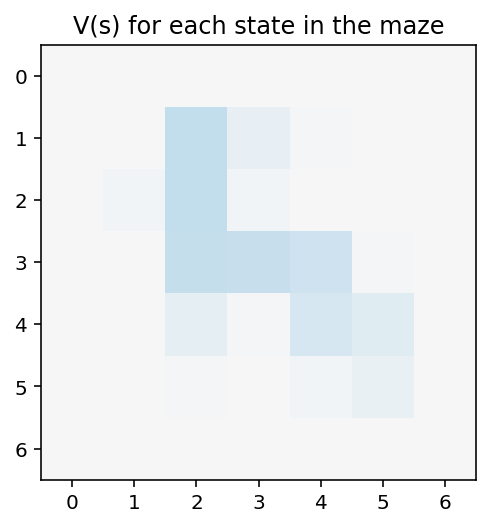

In [14]:
_ = plt.imshow(agent.Q.mean(0).reshape(7, 7), cmap="RdBu", vmin=-1, vmax=1)
_ = plt.title("V(s) for each state in the maze")

Neuro-Nav also includes a tool to plot value and policy values automatically for a given agent and environment. Simply pass the `agent`, `env` and desired agent start position to the `plot_values_and_policy` function.

<AxesSubplot:>

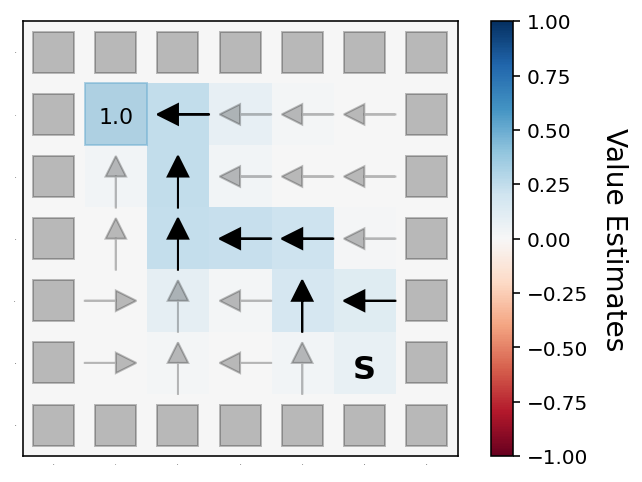

In [15]:
plot_values_and_policy(agent, env, env.agent_start_pos)

### Bonus Questions

* Key to temporal difference learning is the discount factor `gamma`. How does changing the value of `gamma` impact the learning process? 

* The maze environment used here only has a single positive reward location. How might the learning dynamics change if there was also a nearby state with a large negative reward?

## 4. The successor representation

So far, we have focused on learning the set of state-action value estimates directly through experience. This works well in cases where the structure of the environment and the reward function remains fixed. In the real world however, these things change all the time. In this section and the next, we explore algorithms which enable more human-like learning to deal with these kinds of environmental changes. The first such algorithm we will examine is the successor representation (SR) (Dayan, 1993).

![sr agent](../images/notebooks/sr.png)

In an SR algorithm instead of learning cached values, `Q(s, a)` look-up table, two separate entities are learned: a reward function `w(s)`, and a successor matrix `M(s, s', a)`. Both the `w` and `M` functions are learned using variations of the temporal difference learning equations presented above. The two functions can then be combined through matrix multiplication to generate a `Q(s, a)` function on the fly. Code for the SR algorithm is available [here](../neuronav/agents/td_agents.py).

$$ w(s) = w(s) + \alpha * (r - w(s)) $$

$$ M(s, s', a) = M(s, s', a) + \alpha * (onehot(s) + \gamma * M(s', s'', a^{max}) - M(s, s', a))$$

### 4.1 Examining learned representations from an SR agent

We can begin by having a temporal difference SR algorithm learn to solve the same maze environment from above. Once the agent learns to solve the task, we can then examine the learned representations of the separate `w` and `M` functions, along with the `Q` function which results from combining them.

We will use the built-in `run_episode` function to replace the for-loop of agent and environment stepping we've been using until this point. Code for this function is available [here](../neuronav/utils.py).

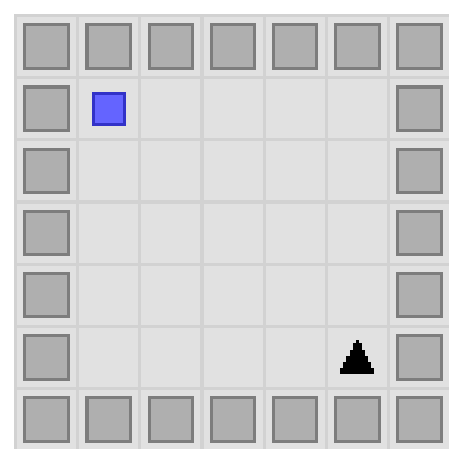

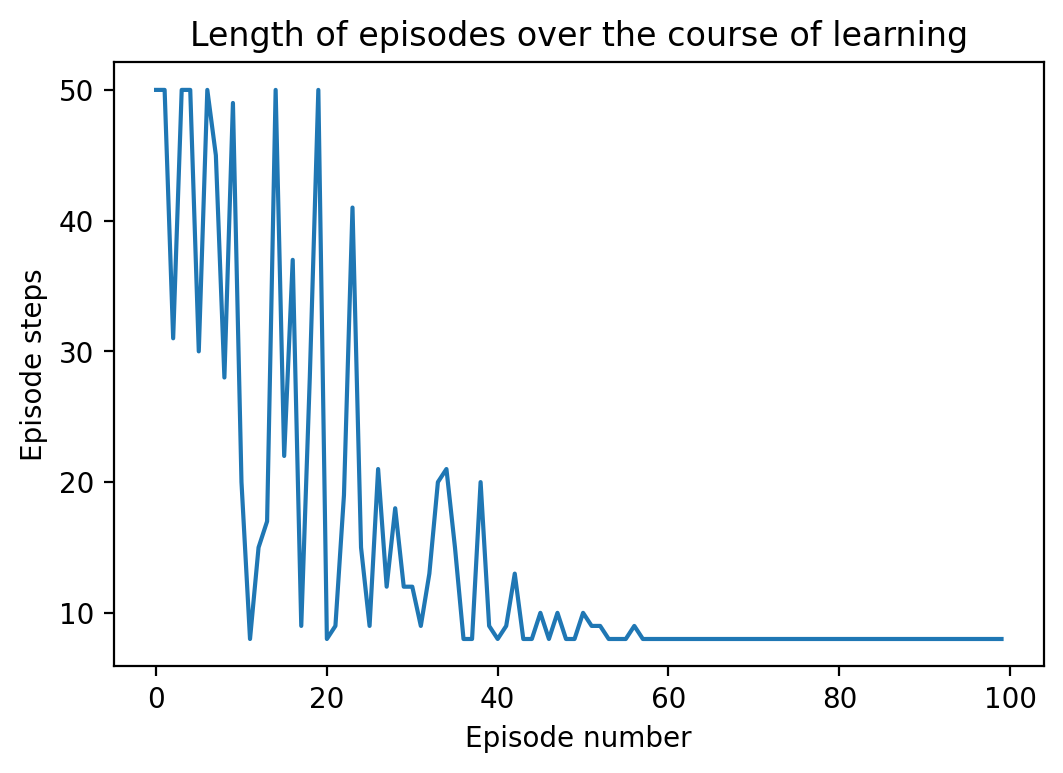

In [16]:
num_episodes = 100
num_steps = 50
lr = 5e-2

env = GridEnv(size=GridSize.micro)
obs = env.reset()
env.render()

agent = TDSR(env.state_size, env.action_space.n, lr=lr)

episode_steps = []
for i in range(num_episodes):
    agent, steps, total_reward = run_episode(env, agent, num_steps)
    episode_steps.append(steps)

plt.plot(episode_steps)
_ = plt.title("Length of episodes over the course of learning")
_ = plt.ylabel("Episode steps")
_ = plt.xlabel("Episode number")
plt.gcf().set_dpi(100)
plt.show()

We can plot the learned reward function `w(s)` below.

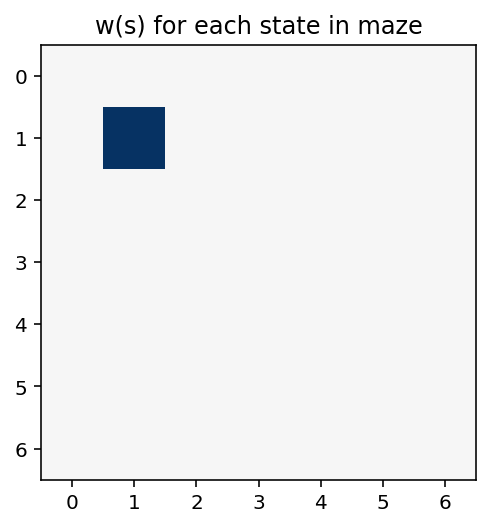

In [17]:
_ = plt.imshow(
    agent.w.reshape(env.grid_size, env.grid_size), cmap="RdBu", vmin=-1, vmax=1
)
_ = plt.title("w(s) for each state in maze")

We can also plot a set of example units from the successor matrix `M(s, s', a)` below.

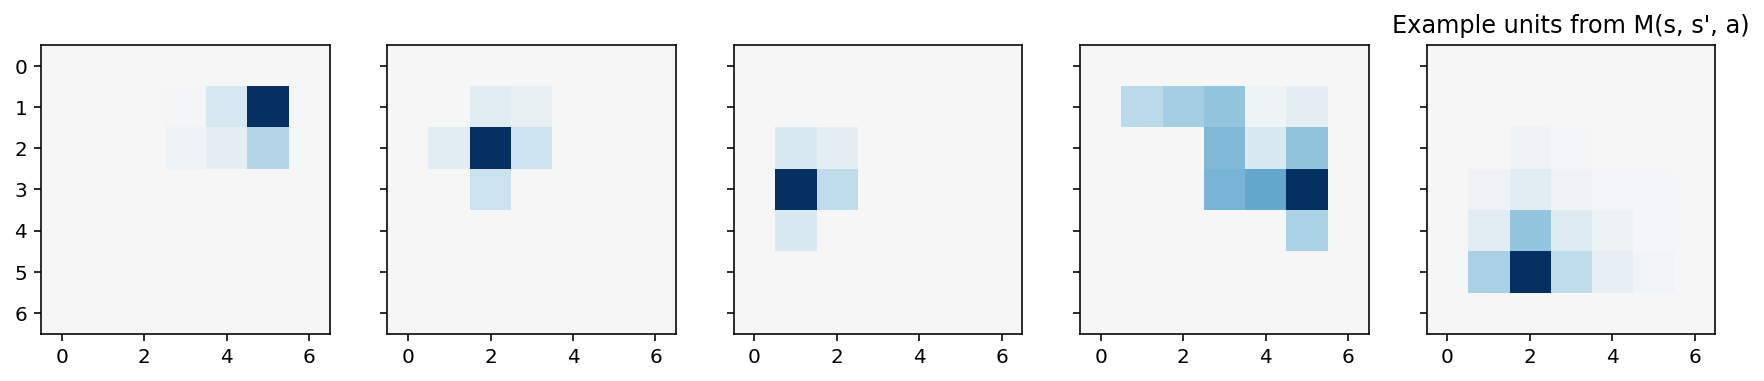

In [18]:
units = [12, 16, 22, 26, 37]

f, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 5))

for idx, unit in enumerate(units):
    axs[idx].imshow(
        np.sqrt(agent.M.mean(0)[unit].reshape(env.grid_size, env.grid_size)),
        cmap="RdBu",
        vmin=-1,
        vmax=1,
    )
plt.title("Example units from M(s, s', a)")
plt.show()

Lastly, it is possible to plot the Q-function which derives from combining the `w(s)` vector and `M(s, s', a)` matrix. 

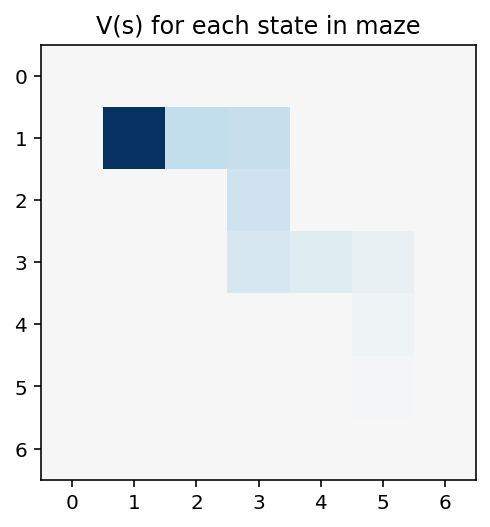

In [19]:
_ = plt.imshow(
    agent.Q.mean(0).reshape(env.grid_size, env.grid_size), cmap="RdBu", vmin=-1, vmax=1
)
_ = plt.title("V(s) for each state in maze")

<AxesSubplot:>

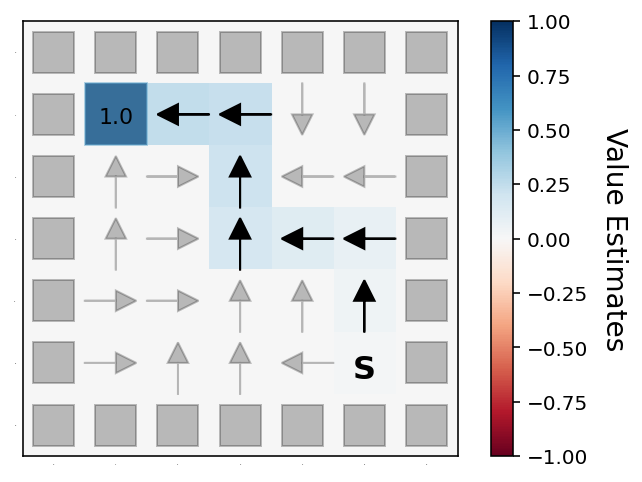

In [20]:
plot_values_and_policy(agent, env, env.agent_start_pos)

### 4.2 Adapting to reward function changes with SR agents

The benefit of learning these entities separately is that different learning dynamics can involved for each, thus enabling faster adaptation to changes in the reward function `w(s)`, for example, while preserving learned knowledge about environment transition dynamics in `M(s, s', a)`. 

We explore this using a simple T-Maze, where the reward location starts at the left corner of the maze, and then switches to the right corner halfway through the learning process (Russek et al., 2017). The traditional Q learning algorithm is unable to adapt to this change, whereas the SR algorithm quickly adjusts its behavior to move toward the new goal location.

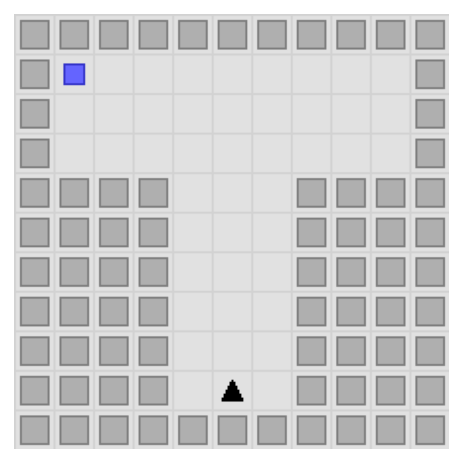

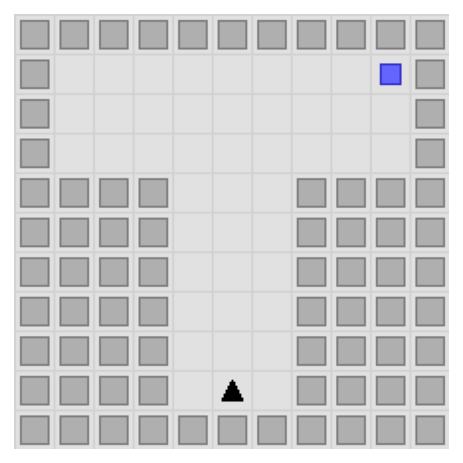

In [21]:
env = GridEnv(template=GridTemplate.t_maze)
obs = env.reset()
env.render()
obs = env.reset(objects={"rewards": {(1, 9): 1}})
env.render()

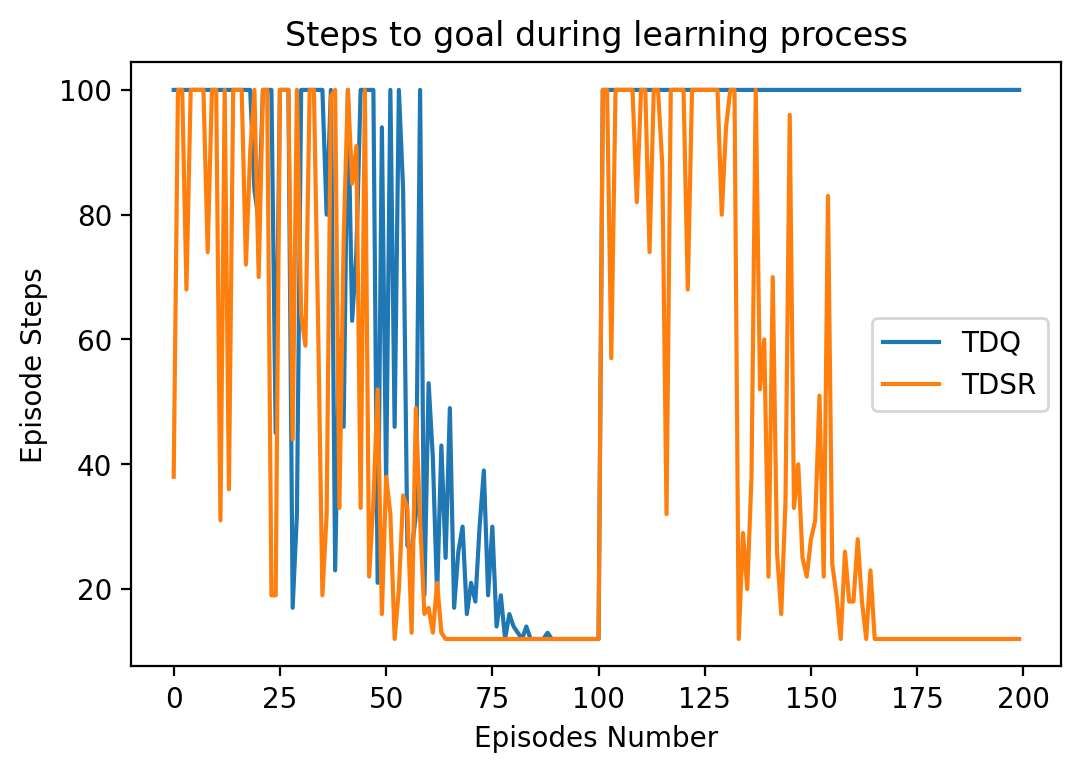

In [22]:
num_episodes = 200
switch_episode = 100
num_steps = 100
goal_loc_a = {(1, 1): 1}
goal_loc_b = {(1, 9): 1}
goal_locs = [goal_loc_a, goal_loc_b]

agent_q = TDQ(env.state_size, env.action_space.n)
agent_sr = TDSR(env.state_size, env.action_space.n)

agents = {"TDQ": agent_q, "TDSR": agent_sr}

for agent_name in agents:
    reward_locs = goal_loc_a
    steps = []
    for i in range(num_episodes):
        if i > switch_episode:
            reward_locs = goal_loc_b
        agents[agent_name], step, _ = run_episode(
            env, agents[agent_name], num_steps, objects={"rewards": reward_locs}
        )
        steps.append(step)
    plt.plot(steps, label=agent_name)
plt.legend()
_ = plt.title("Steps to goal during learning process")
_ = plt.ylabel("Episode Steps")
_ = plt.xlabel("Episodes Number")
plt.gcf().set_dpi(100)
plt.show()

We can plot the learned Q functions for both tasks, and see that the values for the `TDQ` agent still point it towards the original goal location, whereas the `TDSR` agent has learned to modify its values to point toward the new goal location.

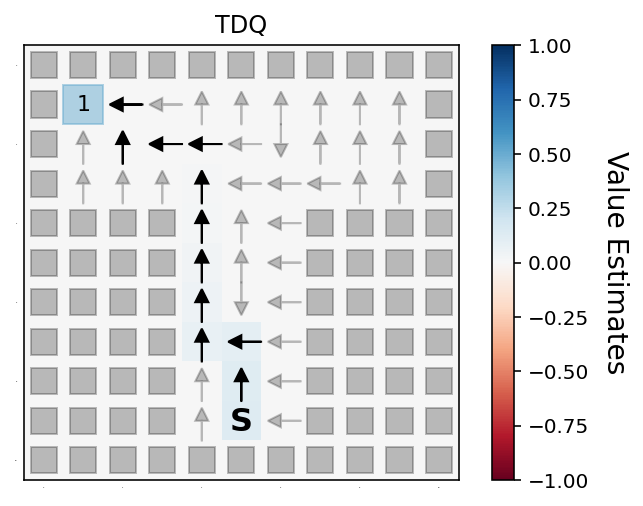

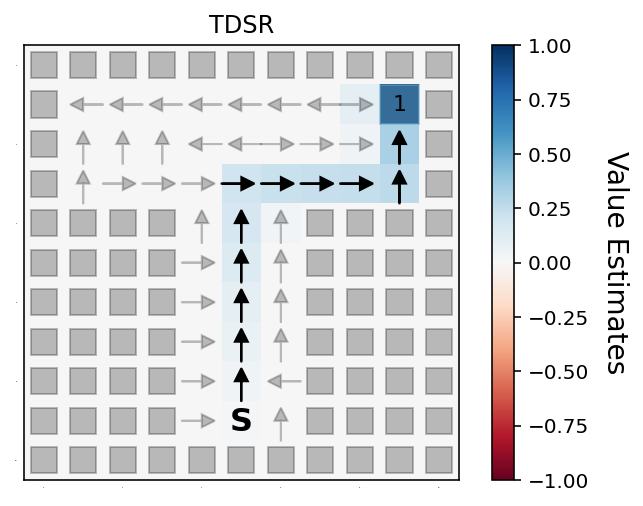

In [23]:
for idx, agent in enumerate(agents):
    plot_values_and_policy(
        agents[agent],
        env,
        env.agent_start_pos,
        plot_title=agent,
        objects={"rewards": goal_locs[idx]},
    )

### Bonus Questions

* Given that the learned reward function `w(s)` is straightforward to interpret, can you design a `w(s)` by hand which leads the agent on a specific path through a maze?

* The successor representation is policy-dependent. Can you think of a task where changing the reward location would require a different-enough policy that there is minimal difference in learning between `TDQ` and `TDSR'?

## 5. Experience replay with Dyna

Thus far we have considered agents which learn exclusively from online experience. Humans and many other animals can learn not only from the current experiences, but from their memories of past experiences. Here we introduce such a memory capacity to agents in the form of an experience replay algorithm called Dyna (Sutton, 1991). 

Agents with Dyna are able to store and re-use past experiences to speed up the learning process, as well as preserve learning from low-probability experiences under the current policy. In the Dyna algorithm, experiences (`<state, action, reward, next_state>`) are stored in a replay buffer as they are gathered during the learning process. These experiences are then sampled between time-steps and used to continue updating the value function (or successor matrix) in an offline fashion. 

![dyna agent](../images/notebooks/dyna.png)

Below we compare a Q-learning agent with and without Dyna on the four-rooms maze navigation task. With the same set of hyperparameters, the Q-learning agent fails to learn the optimal policy within 500 episodes of experience, whereas the DynaQ agent learns the optimal policy in less than 250 episodes of experience.

Code for the Dyna variants of agents is available [here](../neuronav/agents/dyna_agents.py).

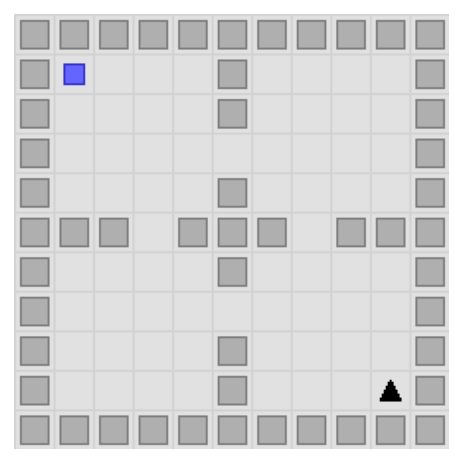

In [24]:
env = GridEnv(template=GridTemplate.four_rooms)
obs = env.reset()
env.render()

KeyboardInterrupt: 

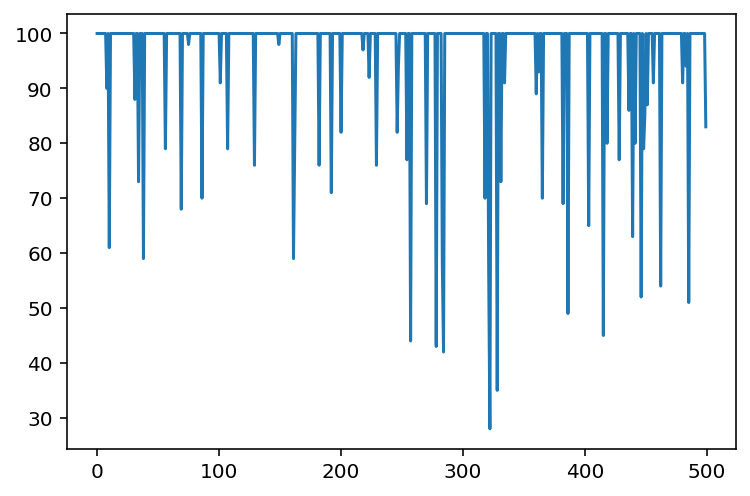

In [25]:
episode_steps = 100
num_episodes = 500
beta = 1e2
lr = 5e-2

agent_q = TDQ(env.state_size, env.action_space.n, beta=beta, lr=lr)
agent_dq = DynaQ(env.state_size, env.action_space.n, beta=beta, lr=lr)

agents = {"TDQ": agent_q, "DynaQ": agent_dq}

for agent_name in agents:
    steps = []
    for i in range(num_episodes):
        agents[agent_name], step, _ = run_episode(
            env, agents[agent_name], episode_steps
        )
        steps.append(step)
    plt.plot(steps, label=agent_name)
plt.legend()
_ = plt.title("Steps to goal during learning process")
_ = plt.ylabel("Episode Steps")
_ = plt.xlabel("Episode Number")
plt.gcf().set_dpi(100)
plt.show()

While the `TDQ` agent has learned to propogate some value to relevant states in the course of 500 episodes, it is much less extensive than what the `DynaQ` agent is able to do in the same number of episodes.

In [ ]:
for agent in agents:
    plot_values_and_policy(agents[agent], env, env.agent_start_pos, plot_title=agent)

### Bonus Questions

* Given that Dyna algorithms store and replay experiences, what would happen if you provided the agent with an initial hand-coded sequence of actions?

* Can you think of a situation in which the Dyna agent might perform worse than an agent without replay?

## 6. Model-based algorithms

Finally, we can extend the idea of learning from past experiences even further. Rather than keeping track of a large dictionary of previous experiences, we can build a model of the reward function and transition dynamics, and use this to compute a Q-function on-the-fly. This belongs to a class of approaches called model-based algorithms. 

In particular, we will use a form of the algorithm called Value Iteration (VI) (Sutton & Barto, 2018). In our VI algorithm, the agent learns two separate functions, a reward function `w(s)`, and a transition function `T(s' | s, a)`. These two functions can then be used to iteratively compute a `Q(s, a)` function by propogating value estimates from rewarding states to all other states using the temporal difference update rule. 

There are multiple benefits of this approach. Like Dyna algorithms, it enables learning with fewer environmental interactions. It also enables adaptation to changes in the environment, since a change in the reward or transition dynamics can be quickly accounted for, and used to compute a new Q-function. 

On the other hand, model-based approaches are much more computationally expensive, since they requires recomputing the Q-function iteratively for all state/action pairs. 

![mb agent](../images/notebooks/mbvi.png)

Below we compare a model-based algorithm (MBV) to a TDQ and DynaQ algorithm on a task where the transition dynamics of the environment change halfway through the learning process. In this case, a roadblock is introduced which requires the agent learning to take the longer detour route to the goal location (Russek et al., 2017).

Code for the model-based algorithm below is available [here](../neuronav/agents/mb_agents.py).

In [ ]:
env = GridEnv(template=GridTemplate.detour)
obs = env.reset()
env.render()

env = GridEnv(template=GridTemplate.detour_block)
obs = env.reset()
env.render()

In [ ]:
episode_steps = 50
num_episodes = 500
switch_episode = 250
beta = 1e2
lr = 1e-1

agent_q = TDQ(env.state_size, env.action_space.n, beta=beta, lr=lr)
agent_sr = TDSR(env.state_size, env.action_space.n, beta=beta, lr=lr)
agent_dq = DynaQ(env.state_size, env.action_space.n, beta=beta, lr=lr)
agent_vi = MBV(env.state_size, env.action_space.n, beta=beta, lr=lr)

agents = {"TDQ": agent_q, "TDSR": agent_sr, "DynaQ": agent_dq, "MBV": agent_vi}

for agent_name in agents:
    steps = []
    env = GridEnv(template=GridTemplate.detour)
    for i in range(num_episodes):
        if i == switch_episode:
            env = GridEnv(template=GridTemplate.detour_block)
        agents[agent_name], step, _ = run_episode(
            env, agents[agent_name], episode_steps
        )
        steps.append(step)
    plt.plot(steps, label=agent_name)
plt.legend()
_ = plt.title("Steps to goal during learning process")
_ = plt.ylabel("Episode Steps")
_ = plt.xlabel("Episode Number")
plt.gcf().set_dpi(100)
plt.show()

In [ ]:
for agent in agents:
    plot_values_and_policy(agents[agent], env, env.agent_start_pos, plot_title=agent)

In the limited number of episodes provided to the agents, only the `MBV` agent is able to learn to adapt to the change in transition dynamics of the environment. This is because the Q function the agent uses can be recomputed based on changes in the underlying transition structure. It is apparent that the `DynaQ` agent has learned something about the detour path, and might be expected to eventually learn to take the detour with enough additional experience.

### Bonus Questions

* It is possible to combine the Dyna and SR algorithms into a single `DynaSR` algorithm, which contains multiple properties of model-based algorithms. What kind of learning would you expect to see with a `DynaSR` algorithm on the task above?

* The model-based agent has to build a transition matrix `T` from experience. What are some potentially more efficient ways to accomplish this?

* In the above task, we introduced a roadblock, and examined whether agents could learn a detour route. How would the three algorithms above compare in an environment when a shortcut was introduced instead of a roadblock?

## 7. Next steps

The content presented in this tutorial notebook is meant to provide an overview of some of the relevant reinforcement learning algorithms used to study human and animal decision making. Learning about these algorithms is just the beginning though. 

Here are some potential next steps:

* Learn about additional Neuro-Nav features in the [Usage Tutorial](./usage_tutorial.ipynb). Some features to explore:

  * Different observation types.

  * Creating your own reward functions.

  * Maze navigation with heading-direction.

* Explore the other notebooks included in Neuro-Nav [here](./README.md).

  * For a deeper dive into human-like learning, see these notebooks ([1](./graph_experiments_1.ipynb), [2](./graph_experiments_2.ipynb)) which replicate results from Momennejad et al., 2017.

  * For a deeper dive into the successor representation, see [this notebook](./representation_experiments.ipynb).

* Explore the agent aglorithms included in Neuro-Nav [here](../neuronav/agents/README.md). Some algorithms not discussed here, but included in Neuro-Nav are:

  * Eligibility Traces

  * Actor Critic

  * DynaSR

* Explore the environments and tasks included in Neuro-Nav [here](../neuronav/envs/README.md).

* Conduct your own experiment by comparing different algorithms, hyperparameters, and tasks.


## References

* Dayan, P. (1993). Improving generalization for temporal difference learning: The successor representation. Neural computation, 5(4), 613-624.

* Gläscher, J., Daw, N., Dayan, P., & O'Doherty, J. P. (2010). States versus rewards: dissociable neural prediction error signals underlying model-based and model-free reinforcement learning. Neuron, 66(4), 585-595.

* Gittins, J. C. (1979). Bandit processes and dynamic allocation indices. Journal of the Royal Statistical Society: Series B (Methodological), 41(2), 148-164.

* Momennejad, I., Russek, E. M., Cheong, J. H., Botvinick, M. M., Daw, N. D., & Gershman, S. J. (2017). The successor representation in human reinforcement learning. Nature human behaviour, 1(9), 680-692.

* Russek, E. M., Momennejad, I., Botvinick, M. M., Gershman, S. J., & Daw, N. D. (2017). Predictive representations can link model-based reinforcement learning to model-free mechanisms. PLoS computational biology, 13(9), e1005768.

* Sutton, R. S. (1991). Dyna, an integrated architecture for learning, planning, and reacting. ACM Sigart Bulletin, 2(4), 160-163.

* Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.

* Watkins, C. J., & Dayan, P. (1992). Q-learning. Machine learning, 8(3), 279-292.